In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam, SGD
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
import time
from scipy import sparse
import joblib

In [2]:
import pandas as pd
from tqdm.auto import tqdm

from timeit import default_timer as timer
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Utils Function

In [5]:
def print_train_time(start:float, end:float, device: torch.device = None):
    """print difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [7]:
def results(res: str):
    res_lst = res.split('\n')

    data = []
    for row in res_lst[3:-4]:
        row_split = [sp.strip() for sp in row[57:].split('  ') if sp != '']
        data.append(row_split)

    index = [l[:57].strip() for l in res_lst[3:-4]]

    head = [c.strip() for c in res_lst[1].strip().split('  ') if c != '']

    df = pd.DataFrame(data, columns=None)
    df.columns = head[1:]
    df.index = index

    return df

# Data

In [8]:
import joblib
from torch.utils import data

In [9]:
train_data = 'train.jb'
valid_data = 'test.jb'

In [10]:
n_workers = 0
batch_size = 128

In [11]:
train_x, train_y = joblib.load(train_data)
val_x, val_y = joblib.load(valid_data)

train_x = np.swapaxes(train_x, 1 , 2)
val_x = np.swapaxes(val_x, 1 , 2)


train_y, val_y = pd.get_dummies(train_y).values, pd.get_dummies(val_y).values

train_set = data.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
valid_set = data.TensorDataset(torch.Tensor(val_x), torch.Tensor(val_y))

In [12]:
train_dataloader = DataLoader(
    train_set,
    batch_size=len(train_set),
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True
  )

val_dataloader = DataLoader(
    valid_set,
    batch_size=len(valid_set),
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True
  )

# Experiament

In [13]:
from model import RCModel
from training_function import seq_learning, learning

In [14]:
device = 'cpu'

In [15]:
model = RCModel(n=20).to(device)
next(model.parameters()).device

device(type='cpu')

### Freezing layers

In [16]:
params = model.state_dict()
params.keys()

odict_keys(['L1.internal_weights', 'L1._input_weights', 'lin_output.weight'])

In [17]:
for name, param in model.named_parameters():  
    if param.requires_grad and 'lin_output' not in name:  
        param.requires_grad = False

## ELM part

In [18]:
optimizer = learning(params=model.parameters())

In [19]:
start_time = timer()
for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
    #X_train, y_train = X_train.cuda(), y_train.cuda()
    if batch_idx == 0:
        H = model.forward_to_hidden(X_train)
        P, Beta = optimizer.init_train(H, y_train)
        
    y_pred = model(X_train)
    acc = accuracy_fn(y_true = y_train.argmax(dim = 1), y_pred = y_pred.argmax(dim = 1))
    print(f'Train acc: {acc:.2f}%')
end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

Train acc: 92.59%
Time Consumtion: 2.0598034000000007 sec


In [20]:
start_time = timer()
model.eval()
for batch_idx, (X_train, y_train) in enumerate(val_dataloader):
        
    y_pred = model(X_train)
    acc = accuracy_fn(y_true = y_train.argmax(dim = 1), y_pred = y_pred.argmax(dim = 1))
    print(f'Validate acc: {acc:.2f}%')
end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

Validate acc: 93.82%
Time Consumtion: 0.6012626000000001 sec


# Resource Consumtions of the Model

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
count_parameters(model)

882

In [23]:
device = 'cpu'
model.to(device)
model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        # Send the data to the target device
        X, y = X.to(device), y.to(device)

        test_pred = model(X)

In [24]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def metrices(y_true, y_pred):
    # y_true is the ground truth labels
    # y_pred is the predicted labels

    cf_matrix = confusion_matrix(y_true, y_pred)

    # Extract the relevant statistics from the confusion matrix
    true_positives = cf_matrix[1, 1]
    false_positives = cf_matrix[0, 1]
    true_negatives = cf_matrix[0, 0]
    false_negatives = cf_matrix[1, 0]

    # Calculate accuracy
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Calculate true positive rate (sensitivity or recall)
    true_positive_rate = true_positives / (true_positives + false_negatives)

    # Calculate true negative rate (specificity)
    true_negative_rate = true_negatives / (true_negatives + false_positives)

    # Calculate precision
    precision = true_positives / (true_positives + false_positives)

    # Calculate false positive rate (fall-out)
    false_positive_rate = false_positives / (false_positives + true_negatives)

    # Calculate F1 score
    f1_score = 2 * (precision * true_positive_rate) / (precision + true_positive_rate)

    # print(f'accuracy: {100*accuracy:.2f} | true_positive_rate: {100*true_positive_rate:.2f} | true_negative_rate: {100*true_negative_rate:.2f} | precision: {100*precision:.2f} | false_positive_rate: {100*false_positive_rate:.2f} | f1_score: {100*f1_score:.2f}')
    return [accuracy, true_positive_rate, true_negative_rate, precision, false_positive_rate, f1_score]

In [26]:
y_pred = test_pred.argmax(dim=1).cpu().numpy()
y_true = y.argmax(dim=1).cpu().numpy()
accuracy, true_positive_rate, true_negative_rate, precision, false_positive_rate, f1_score = met_test = metrices(y_true, y_pred)
print(f'accuracy: {100*accuracy:.2f} | true_positive_rate: {100*true_positive_rate:.2f} | true_negative_rate: {100*true_negative_rate:.2f} | precision: {100*precision:.2f} | false_positive_rate: {100*false_positive_rate:.2f} | f1_score: {100*f1_score:.2f}')

accuracy: 93.76 | true_positive_rate: 96.99 | true_negative_rate: 92.64 | precision: 82.06 | false_positive_rate: 7.36 | f1_score: 88.90


In [27]:
cf_matrix = confusion_matrix(y_true, y_pred)

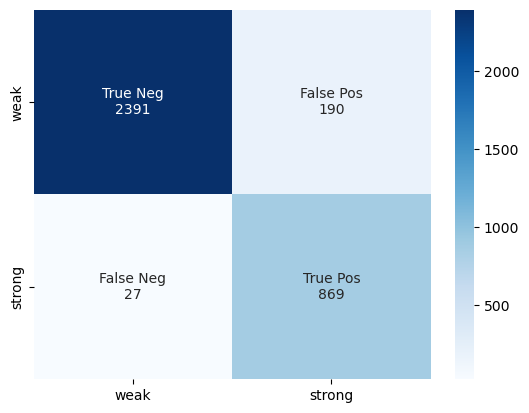

In [28]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

categories = ["weak", "strong"]
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.savefig('cf_mat_cnn.png')

In [29]:
device = 'cuda'
Metrice_list = []
for _ in tqdm(range(20)):
    for i in np.arange(5, 55, 5):
        torch.manual_seed(42)
        model = RCModel(n=i).to(device)
        n_params = count_parameters(model)
        optimizer = learning(params=model.parameters())

        for name, param in model.named_parameters():  
            if param.requires_grad and 'lin_output' not in name:  
                param.requires_grad = False

        model.train()
        start_time = timer()
        for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
            if device == 'cuda':
                X_train, y_train = X_train.cuda(), y_train.cuda()
            if batch_idx == 0:
                H = model.forward_to_hidden(X_train)
                P, Beta = optimizer.init_train(H, y_train)

            y_pred = model(X_train)
            acc = accuracy_fn(y_true = y_train.argmax(dim = 1), y_pred = y_pred.argmax(dim = 1))
        end_time = timer()
        time_consume_train = end_time - start_time
        
        model.eval()
        start_time = timer()
        with torch.inference_mode():
            for X, y in val_dataloader:
                if device == 'cuda':
                    X, y = X.cuda(), y.cuda()

                test_pred = model(X)
        end_time = timer()
        time_consume_pred = end_time - start_time

        y_pred = test_pred.argmax(dim=1).cpu().numpy()
        y_true = y.argmax(dim=1).cpu().numpy()
        met_test = metrices(y_true, y_pred)
        Metrice_list.append(met_test + [time_consume_train, time_consume_pred, i, n_params])
        # print('='*150)

df = pd.DataFrame(Metrice_list)
df.columns = ['accuracy','true_positive_rate','true_negative_rate','precision','false_positive_rate','f1_score', 'time spent(training)', 'time spent(testing)', 'n_internal', 'n_params']
df.head()
df.to_csv(f'{device}_rc_metrice.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
device = 'cpu'
Metrice_list = []
for _ in tqdm(range(20)):
    for i in np.arange(5, 55, 5):
        torch.manual_seed(42)
        model = RCModel(n=i).to(device)
        n_params = count_parameters(model)
        optimizer = learning(params=model.parameters())

        for name, param in model.named_parameters():  
            if param.requires_grad and 'lin_output' not in name:  
                param.requires_grad = False

        model.train()
        start_time = timer()
        for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
            if device == 'cuda':
                X_train, y_train = X_train.cuda(), y_train.cuda()
            if batch_idx == 0:
                H = model.forward_to_hidden(X_train)
                P, Beta = optimizer.init_train(H, y_train)

            y_pred = model(X_train)
            acc = accuracy_fn(y_true = y_train.argmax(dim = 1), y_pred = y_pred.argmax(dim = 1))
        end_time = timer()
        time_consume_train = end_time - start_time
        
        model.eval()
        start_time = timer()
        with torch.inference_mode():
            for X, y in val_dataloader:
                if device == 'cuda':
                    X, y = X.cuda(), y.cuda()

                test_pred = model(X)
        end_time = timer()
        time_consume_pred = end_time - start_time

        y_pred = test_pred.argmax(dim=1).cpu().numpy()
        y_true = y.argmax(dim=1).cpu().numpy()
        met_test = metrices(y_true, y_pred)
        Metrice_list.append(met_test + [time_consume_train, time_consume_pred, i, n_params])
        # print('='*150)

df = pd.DataFrame(Metrice_list)
df.columns = ['accuracy','true_positive_rate','true_negative_rate','precision','false_positive_rate','f1_score', 'time spent(training)', 'time spent(testing)', 'n_internal', 'n_params']
df.head()
df.to_csv(f'{device}_rc_metrice.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

There are several metrics that are commonly used to measure the performance of binary classifiers:

1. Accuracy: This is the proportion of correct predictions made by the classifier, and is calculated as the number of true positive and true negative predictions divided by the total number of predictions made.

2. True positive rate (TPR) or sensitivity: This is the proportion of positive instances that were correctly predicted by the classifier, and is calculated as the number of true positive predictions divided by the total number of positive instances.

3. True negative rate (TNR) or specificity: This is the proportion of negative instances that were correctly predicted by the classifier, and is calculated as the number of true negative predictions divided by the total number of negative instances.

4. Precision: This is the proportion of positive predictions that were actually correct, and is calculated as the number of true positive predictions divided by the total number of positive predictions made by the classifier.

5. False positive rate (FPR) or fall-out: This is the proportion of negative instances that were incorrectly predicted as positive, and is calculated as the number of false positive predictions divided by the total number of negative instances.

6. F1 score: This is a balance between precision and recall, and is calculated as the harmonic mean of precision and recall.

Overall, the choice of which performance metric to use will depend on the specific requirements of the application. Some metrics, such as accuracy and F1 score, provide a general overview of classifier performance, while others, such as true positive rate and false positive rate, are more specialized and may be more relevant in certain situations.